<img src="pic1.jpg">

## <center>Movie Recommendation Systems </center>

This notebook provides my work on recommendation/filtering systems using a movie database from https://www.kaggle.com/rounakbanik/the-movies-dataset. 

This work first provides an exploratory analysis of the dataset, identify several possible questions to gain some insights of the data and followed by the development of three different recommendation systems i.e. content-based recommendation system, collaborative recommendation system and hybrid recommendation system.


In [2]:
# Loading all libraries
# Some of the libraries here were added later on in the development of this notebook but i just put everything here 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import operator
from collections import Counter
from surprise import Reader, Dataset, SVD, SVDpp, evaluate
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the dataset using pandas

data=pd.read_csv('movies_metadata.csv')
keyword=pd.read_csv('keywords.csv')
credit=pd.read_csv('credits.csv')
links_small = pd.read_csv('links_small.csv')


# 1.  Exploratory Data Analysis

In [4]:
data.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

-  We'll be using the genres,id, overview, production_companies, production_countries, release_date, tagline and title columns. Thus, ropping all the other columns.

In [6]:
df=data.drop([u'adult', u'belongs_to_collection', u'budget', u'homepage',
       u'imdb_id', u'original_language', u'original_title',
       u'popularity', u'poster_path',
       u'revenue', u'runtime',
       u'spoken_languages', u'status', u'video',
       u'vote_average', u'vote_count'],axis=1)

In [7]:
df.head()

,genres,id,overview,production_companies,production_countries,release_date,tagline,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,NaN,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,Roll the dice and unleash the excitement!,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,Friends are the people who let you be yourself...,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 8 columns):
genres                  45466 non-null object
id                      45466 non-null object
overview                44512 non-null object
production_companies    45463 non-null object
production_countries    45463 non-null object
release_date            45379 non-null object
tagline                 20412 non-null object
title                   45460 non-null object
dtypes: object(8)
memory usage: 2.8+ MB


-  Fill the null rows of 'tagline' and 'overview' columns and drop the rest of null rows in the dataframe.

In [9]:
df['overview']=df['overview'].fillna('')

In [10]:
df['tagline']=df['tagline'].fillna('')

In [11]:
df.dropna(inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45376 entries, 0 to 45465
Data columns (total 8 columns):
genres                  45376 non-null object
id                      45376 non-null object
overview                45376 non-null object
production_companies    45376 non-null object
production_countries    45376 non-null object
release_date            45376 non-null object
tagline                 45376 non-null object
title                   45376 non-null object
dtypes: object(8)
memory usage: 3.1+ MB


In [13]:
df.head()

,genres,id,overview,production_companies,production_countries,release_date,tagline,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,Roll the dice and unleash the excitement!,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,Friends are the people who let you be yourself...,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II


-  The dataframe is now ready for further pre-procesing and explarotary analysis. The following generate further pre-processing for genres, production_companies, production_countries, release_date and title columns.

In [14]:
df['genres']=df['genres'].apply(literal_eval)
df['genres']=df['genres'].apply(lambda x:[u['name'] for u in x])

In [15]:
df['production_companies']=df['production_companies'].apply(literal_eval)
df['production_companies']=df['production_companies'].apply(lambda x:[u['name'] for u in x])

In [16]:
df['production_countries']=df['production_countries'].apply(literal_eval)
df['production_countries']=df['production_countries'].apply(lambda x:[u['name'] for u in x])

In [17]:
df['release_date']=df['release_date'].apply(lambda x:pd.to_datetime(x).year)


In [18]:
df['title']=df['title'].apply(lambda x:str(x))

In [19]:
df.head()

,genres,id,overview,production_companies,production_countries,release_date,tagline,title
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",[Pixar Animation Studios],[United States of America],1995,,Toy Story
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995,Roll the dice and unleash the excitement!,Jumanji
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,"[Warner Bros., Lancaster Gate]",[United States of America],1995,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",[Twentieth Century Fox Film Corporation],[United States of America],1995,Friends are the people who let you be yourself...,Waiting to Exhale
4,[Comedy],11862,Just when George Banks has recovered from his ...,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II


-  Change the id datatype to integer.

In [20]:
df['id']=df['id'].astype('int')

-  The pre-processing for the main dataframe is completed. Now, we have to process the credit file (file with cast, crew info) before we merge the credit dataframe with the main dataframe.

In [21]:
# Looking at credit file to analyse the cast and crew

credit.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [22]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [23]:
credit['crew']=credit['crew'].apply(literal_eval)
credit['crew']=credit['crew'].apply(lambda x:[u['name'].replace(" ","") for u in x if u['job']=='Director'])

In [24]:
credit['cast']=credit['cast'].apply(literal_eval)
credit['cast']=credit['cast'].apply(lambda x:[u['name'].replace(" ","")  for u in x if u['order'] in [0,1]] )

In [25]:
credit.head()

,cast,crew,id
0,"[TomHanks, TimAllen]",[JohnLasseter],862
1,"[RobinWilliams, JonathanHyde]",[JoeJohnston],8844
2,"[WalterMatthau, JackLemmon]",[HowardDeutch],15602
3,"[WhitneyHouston, AngelaBassett]",[ForestWhitaker],31357
4,"[SteveMartin, DianeKeaton]",[CharlesShyer],11862


In [26]:
# Merge the 2 dataframe 

df=df.merge(credit, on='id')

In [27]:
df.head()

,genres,id,overview,production_companies,production_countries,release_date,tagline,title,cast,crew
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",[Pixar Animation Studios],[United States of America],1995,,Toy Story,"[TomHanks, TimAllen]",[JohnLasseter]
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995,Roll the dice and unleash the excitement!,Jumanji,"[RobinWilliams, JonathanHyde]",[JoeJohnston]
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,"[Warner Bros., Lancaster Gate]",[United States of America],1995,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[WalterMatthau, JackLemmon]",[HowardDeutch]
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",[Twentieth Century Fox Film Corporation],[United States of America],1995,Friends are the people who let you be yourself...,Waiting to Exhale,"[WhitneyHouston, AngelaBassett]",[ForestWhitaker]
4,[Comedy],11862,Just when George Banks has recovered from his ...,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[SteveMartin, DianeKeaton]",[CharlesShyer]


In [28]:
# Rearrange the columns
df=df[[u'id', u'title', u'genres', u'cast', u'crew', u'overview', u'tagline',u'production_countries', u'production_companies',u'release_date']]
 

We have derived several questions related to the dataset and the following analyses will try to answer the those questions:
1. How is the movie - genres frequencies look likes?
2. What is the production company that produced most movies?
3. Which country produced most movies?
4. Name some of the leading actors that involved in most movies? 

In [29]:
pd.DataFrame(df['genres'].tolist()).stack().value_counts()

Drama              20302
Comedy             13195
Thriller            7635
Romance             6744
Action              6603
Horror              4676
Crime               4312
Documentary         3926
Adventure           3506
Science Fiction     3054
Family              2774
Mystery             2474
Fantasy             2322
Animation           1942
Foreign             1627
Music               1600
History             1397
War                 1325
Western             1042
TV Movie             768
dtype: int64

In [30]:
#Let's look at movies genres tabulation before 1900 till 2017

import seaborn as sns

df1900=pd.DataFrame(df[df['release_date']<1900]['genres'].tolist()).stack().value_counts().reset_index()
df1950=pd.DataFrame(df[(df['release_date']>=1900) & (df['release_date']<1950)]['genres'].tolist()).stack().value_counts().reset_index()
df2000=pd.DataFrame(df[(df['release_date']>=1950) & (df['release_date']<2000)]['genres'].tolist()).stack().value_counts().reset_index()
df2020=pd.DataFrame(df[df['release_date']>=2000]['genres'].tolist()).stack().value_counts().reset_index()
df2020.columns=['Genres','Counts']
df1900.columns=['Genres','Counts']
df2000.columns=['Genres','Counts']
df1950.columns=['Genres','Counts']

Text(0.5,0.98,'Movie Genres Plot before 1900 to 2020')

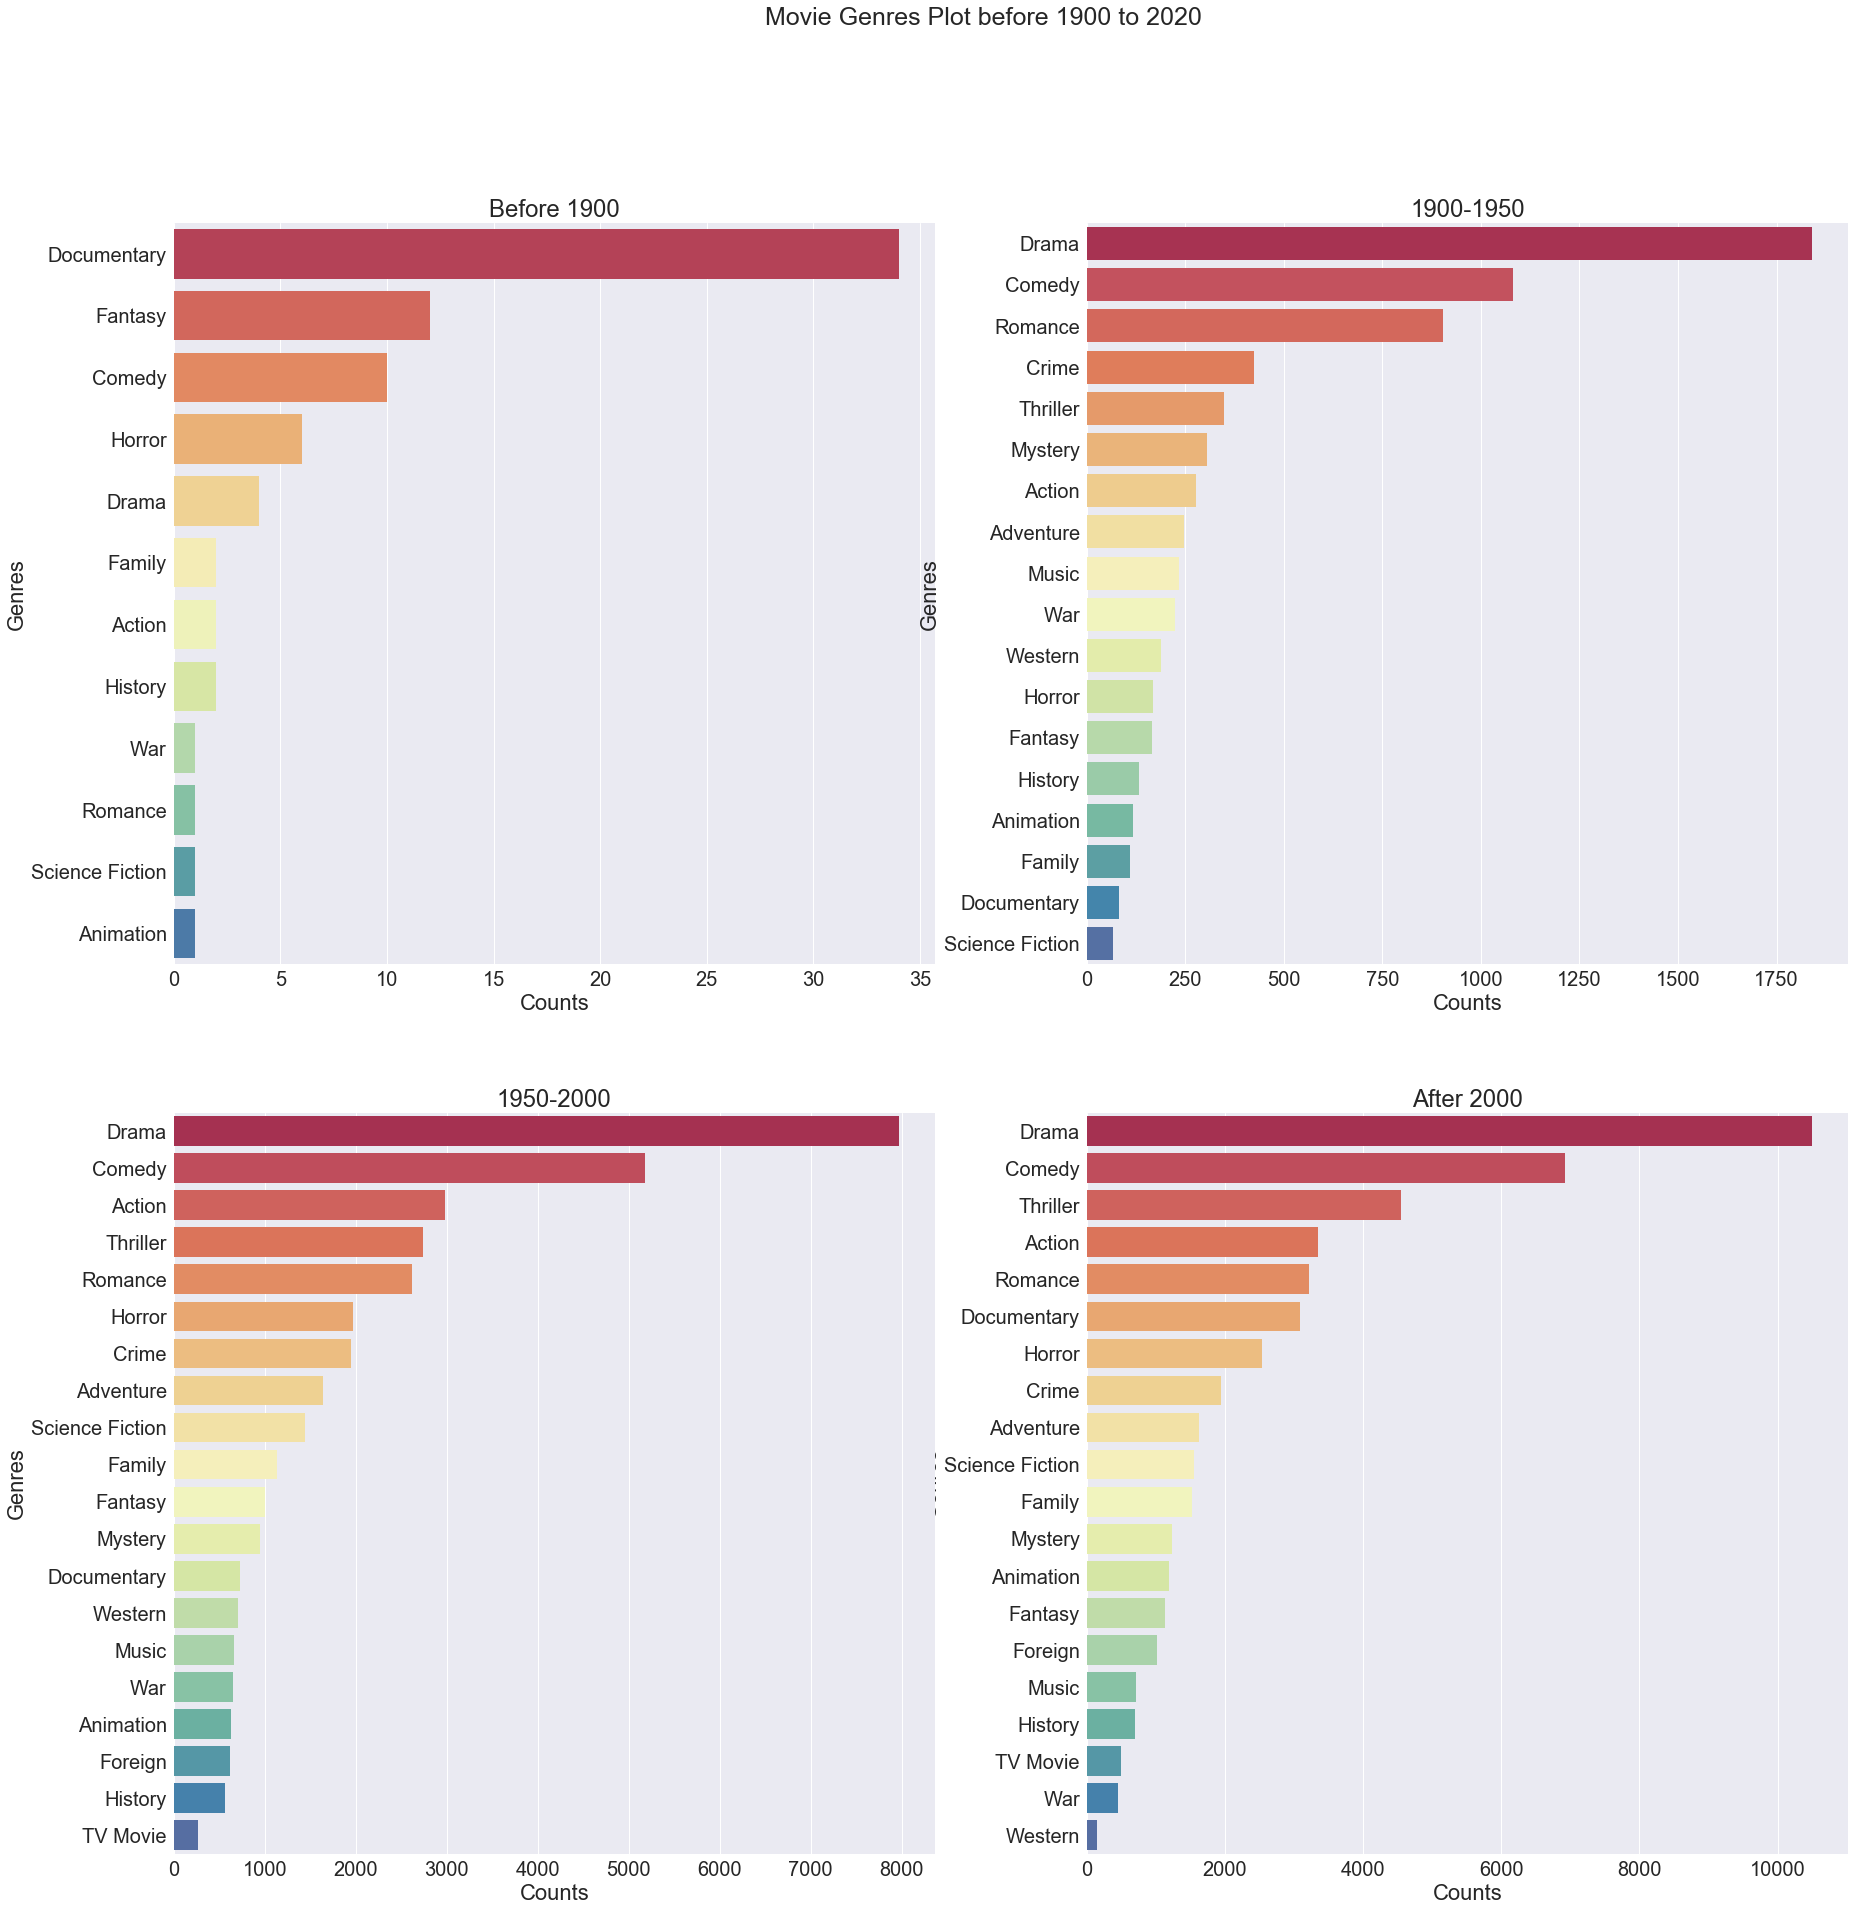

In [31]:
sns.set(style="whitegrid")
sns.set(font_scale=2)

plt.figure(2, figsize=(30,30))
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0],  title='Before 1900')
sns.barplot(x='Counts',y='Genres', data=df1900, palette='Spectral')

plt.subplot(the_grid[1, 1], title='After 2000')
sns.barplot(x='Counts',y='Genres', data=df2020, palette='Spectral')

plt.subplot(the_grid[0, 1],  title='1900-1950')
sns.barplot(x='Counts',y='Genres', data=df1950, palette='Spectral')

plt.subplot(the_grid[1, 0], title='1950-2000')
sns.barplot(x='Counts',y='Genres', data=df2000, palette='Spectral')
plt.suptitle('Movie Genres Plot before 1900 to 2020', fontsize=25)


-  Let's see the top 10 productions companies that produced most movies and the movie genres they like to produce.

In [32]:
p_com=pd.DataFrame(df['production_companies'].tolist()).stack().value_counts()[0:9]
p_com

Warner Bros.                              1250
Metro-Goldwyn-Mayer (MGM)                 1080
Paramount Pictures                        1007
Twentieth Century Fox Film Corporation     836
Universal Pictures                         830
Columbia Pictures Corporation              448
Canal+                                     442
Columbia Pictures                          431
RKO Radio Pictures                         290
dtype: int64

The following is a function to analyse the movie genres produced by production companies

In [33]:
def get_freq(dat,top,col):
    stats=[]
    d=df.apply(lambda x: stats.extend(x['genres']) if dat.index[0] in x[col] else stats.extend([]),axis=1)
    st=pd.DataFrame(Counter(stats).most_common())
    st.columns=['Genres',dat.index[0]]
    for i in range(1,top):
        stats1=[]
        d=df.apply(lambda x: stats1.extend(x['genres']) if dat.index[i] in x[col] else stats.extend([]),axis=1)
        st1=pd.DataFrame(Counter(stats1).most_common())
        st1.columns=['Genres',dat.index[i]]
        st=st.merge(st1,on='Genres')
    return st

In [34]:
#Top 5 production companies with the genres distributions

get_freq(p_com,5,'production_companies')

,Genres,Warner Bros.,Metro-Goldwyn-Mayer (MGM),Paramount Pictures,Twentieth Century Fox Film Corporation,Universal Pictures
0,Drama,656,597,459,432,319
1,Comedy,401,382,408,308,357
2,Action,278,154,198,202,187
3,Romance,262,358,259,193,157
4,Crime,253,137,131,120,125
5,Thriller,252,153,215,194,197
6,Adventure,191,121,154,136,122
7,Mystery,106,77,91,74,77
8,Fantasy,103,44,40,58,68
9,Family,88,58,69,85,81


In [35]:
# Let's look at the production companies frequencies

p_cou=pd.DataFrame(df['production_countries'].tolist()).stack().value_counts()[0:9]
p_cou

United States of America    21176
United Kingdom               4100
France                       3956
Germany                      2266
Italy                        2174
Canada                       1766
Japan                        1654
Spain                         964
Russia                        911
dtype: int64

In [36]:
get_freq(p_cou,5,'production_countries')

,Genres,United States of America,United Kingdom,France,Germany,Italy
0,Drama,9059,2147,2425,1317,997
1,Comedy,6842,1011,1190,563,657
2,Thriller,4371,924,524,380,299
3,Action,3702,565,312,251,272
4,Romance,3581,657,716,292,265
5,Horror,2687,521,207,174,265
6,Crime,2445,482,412,204,249
7,Adventure,2128,455,246,182,174
8,Science Fiction,1863,291,130,121,82
9,Family,1732,209,107,113,22


In [37]:
# The lead actors involved in most movies

p_cas=pd.DataFrame(df['cast'].tolist()).stack().value_counts()[0:9]
p_cas

JohnWayne          104
JackieChan          85
RobertDeNiro        74
MichaelCaine        74
GérardDepardieu     73
NicolasCage         66
ChristopherLee      61
BetteDavis          60
JeffBridges         60
dtype: int64

In [38]:
get_freq(p_cas,5,'cast')

,Genres,JohnWayne,JackieChan,RobertDeNiro,MichaelCaine,GérardDepardieu
0,Action,49,76,11,26,5
1,Drama,44,24,43,45,48
2,Adventure,24,21,3,8,6
3,Romance,21,4,11,7,21
4,War,13,2,1,6,2
5,Comedy,8,46,27,23,33
6,History,5,2,3,2,10
7,Thriller,4,23,16,32,11
8,Crime,2,21,24,20,13
9,Mystery,1,1,5,7,2


That's it for exploratory analysis, let's process the keyword file and merge with our dataframe.

# 2.  Content-based Recommendation System

We'll be using the keyword contents in this recomendation system and thus the pre-processing of the contents.

In [39]:
keyword['keywords']=keyword['keywords'].apply(literal_eval)
keyword['keywords']=keyword['keywords'].apply(lambda x:[u['name']for u in x])


In [40]:
keyword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [41]:
# Merge into previous dataframe

df=df.merge(keyword, on='id')

In [42]:
df.head()

,id,title,genres,cast,crew,overview,tagline,production_countries,production_companies,release_date,keywords
0,862,Toy Story,"[Animation, Comedy, Family]","[TomHanks, TimAllen]",[JohnLasseter],"Led by Woody, Andy's toys live happily in his ...",,[United States of America],[Pixar Animation Studios],1995,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[RobinWilliams, JonathanHyde]",[JoeJohnston],When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,[United States of America],"[TriStar Pictures, Teitler Film, Interscope Co...",1995,"[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,"[Romance, Comedy]","[WalterMatthau, JackLemmon]",[HowardDeutch],A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,[United States of America],"[Warner Bros., Lancaster Gate]",1995,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[WhitneyHouston, AngelaBassett]",[ForestWhitaker],"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,[United States of America],[Twentieth Century Fox Film Corporation],1995,"[based on novel, interracial relationship, sin..."
4,11862,Father of the Bride Part II,[Comedy],"[SteveMartin, DianeKeaton]",[CharlesShyer],Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,[United States of America],"[Sandollar Productions, Touchstone Pictures]",1995,"[baby, midlife crisis, confidence, aging, daug..."


This recommendation system and also the following two systems will be using a subset of the main dataframe. We'll be using the movie Id in the 'links_small' file to link and gather the subset data.

In [43]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [44]:
links_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
imdbId     9125 non-null int64
tmdbId     9112 non-null float64
dtypes: float64(1), int64(2)
memory usage: 213.9 KB


In [45]:
# Drop the null rows

links_small.dropna(inplace=True)

In [46]:
links_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9112 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9112 non-null int64
imdbId     9112 non-null int64
tmdbId     9112 non-null float64
dtypes: float64(1), int64(2)
memory usage: 284.8 KB


In [47]:
# Map the dataframe to the subset file.

df=df[df['id'].isin(links_small['tmdbId'].astype('int'))]

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9219 entries, 0 to 41608
Data columns (total 11 columns):
id                      9219 non-null int32
title                   9219 non-null object
genres                  9219 non-null object
cast                    9219 non-null object
crew                    9219 non-null object
overview                9219 non-null object
tagline                 9219 non-null object
production_countries    9219 non-null object
production_companies    9219 non-null object
release_date            9219 non-null int64
keywords                9219 non-null object
dtypes: int32(1), int64(1), object(9)
memory usage: 828.3+ KB


In [49]:
# Concantenate the overview and tagline columns

df['description']=df['overview']+df['tagline']

In [50]:
# Concantenate the genres, crew,cast and keywords columns

df['all'] = df['genres'] + df['crew'] + df['cast'] + df['keywords']
df['all']=df['all'].apply(lambda x:' '.join(x))

In [51]:
df=df.reset_index()
df=df.reindex(index=range(0,len(df)))

-  The tfidf and countvector matrix is generated in the following cells for the computation of cosine similarity distance

In [52]:
tf1 = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=0, stop_words='english')
tfidf1 = tf1.fit_transform(df['all'])

In [53]:
tf2 = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf2 = tf2.fit_transform(df['description'])

In [54]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 1),min_df=0, stop_words='english')
count_v = count.fit_transform(df['all'])


In [55]:
tfidf1.shape

(9219, 19675)

In [56]:
tfidf2.shape

(9219, 268124)

In [57]:
count_v.shape

(9219, 19675)

-  The following cosine similarity uses tfidf with different ngram range, countvectorizer and a weighted sum of the two similarity from tfidf.

In [58]:
cosine_sim1 = linear_kernel(tfidf1, tfidf1)

In [59]:
cosine_sim2 = linear_kernel(tfidf2, tfidf2)

In [60]:
cosine_sim3 = cosine_similarity(count_v, count_v)


In [61]:
cosine_sim0=cosine_sim1+cosine_sim2

Function to retrieve the list of recommended movies

In [62]:
def get_movie_rec(movie,sim):
    if sim==0:
        cosine_sim=cosine_sim0
    if sim==1:
        cosine_sim=cosine_sim1
    if sim==2:
        cosine_sim=cosine_sim2 
    if sim==3:
        cosine_sim=cosine_sim3 
    idx=df[df['title']== movie].index[0]
    sim=list(enumerate(cosine_sim[idx]))
    sort_sim=sorted(sim, key=operator.itemgetter(1), reverse=True)[1:11]
    sort_idx=[i[0] for i in sort_sim]
    return df.iloc[sort_idx]['title']
    

- The following is the recommendation result for the query movie 'Dark Knight'

In [63]:
get_movie_rec('The Dark Knight',0)

8031                      The Dark Knight Rises
6218                              Batman Begins
1134                             Batman Returns
7659                 Batman: Under the Red Hood
524                                      Batman
132                              Batman Forever
1260                             Batman & Robin
8334    Batman: The Dark Knight Returns, Part 2
8001                           Batman: Year One
2599               Batman: Mask of the Phantasm
Name: title, dtype: object

In [64]:
get_movie_rec('The Dark Knight',1)

6218                         Batman Begins
8031                 The Dark Knight Rises
1134                        Batman Returns
7659            Batman: Under the Red Hood
524                                 Batman
1260                        Batman & Robin
2133                          Superman III
132                         Batman Forever
8592                          Wonder Woman
9024    Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [65]:
get_movie_rec('The Dark Knight',2)

8031                      The Dark Knight Rises
132                              Batman Forever
1134                             Batman Returns
8334    Batman: The Dark Knight Returns, Part 2
7659                 Batman: Under the Red Hood
524                                      Batman
8001                           Batman: Year One
2599               Batman: Mask of the Phantasm
2716                                        JFK
8265    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [66]:
get_movie_rec('The Dark Knight',3)

6218                 Batman Begins
8031         The Dark Knight Rises
1260                Batman & Robin
7659    Batman: Under the Red Hood
524                         Batman
1134                Batman Returns
5809                   Point Blank
7582                      Defendor
8467                    Kick-Ass 2
1031                             M
Name: title, dtype: object

# 3.  Collaborative Recommendation System

This system will employ the movie ratings made by the viewer. The recommendations will be done using svd approach from the 'Surprise' library.

In [66]:
# Loading the rating file
rating=pd.read_csv('ratings_small.csv')

In [67]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [68]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [69]:
reader = Reader()

In [70]:
# Read the rating dataframe and split into 5 fold for cross validations

df_r = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
df_r.split(n_folds=5)

Using SVD to perform 5 fold crossvalidation using both Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) measures.

In [71]:
svd = SVD()
evaluate(svd, df_r, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8856
MAE:  0.6820
------------
Fold 2
RMSE: 0.8962
MAE:  0.6911
------------
Fold 3
RMSE: 0.9033
MAE:  0.6966
------------
Fold 4
RMSE: 0.9000
MAE:  0.6916
------------
Fold 5
RMSE: 0.9003
MAE:  0.6933
------------
------------
Mean RMSE: 0.8971
Mean MAE : 0.6909
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.68199108330579572,
                             0.69110685892498414,
                             0.69658029808777044,
                             0.69164532619787766,
                             0.69326065760418665],
                            'rmse': [0.88559383129859914,
                             0.89623223382962913,
                             0.90327385166392926,
                             0.89999608655980401,
                             0.90026925923448509]})

Using SVD to train the rating dataset

In [72]:
trainset = df_r.build_full_trainset()
svd.train(trainset)


Let's see user no 1 ratings and predict his/her rating

In [73]:
rating[rating['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


Let's predict his/her ratings for low,medium and high ratings i.e. movie ID 1405, 31 and 2105

In [74]:
svd.predict(1, 1405)

Prediction(uid=1, iid=1405, r_ui=None, est=2.0715824192721639, details={'was_impossible': False})

In [75]:
svd.predict(1, 31)

Prediction(uid=1, iid=31, r_ui=None, est=2.4183501003953896, details={'was_impossible': False})

In [76]:
svd.predict(1, 2105)

Prediction(uid=1, iid=2105, r_ui=None, est=2.8508488454784078, details={'was_impossible': False})

The predicted ratings seems to work on average rating but perform quite poorly on low and high ratings though.

# 4.  Hybrid Recommendation System



The first and second recommendations sytems employed the content-based filtering approach and ratings from the existing users. The former deals with features from the movies only and do not consider the user profiles/features. Using both approaches we can actually develop a recommendation that is more personalized.

The following function provides a personalized recommendation that combines the previous two approaches. 

In [77]:
def get_recommend(userId,movie):
    movies=pd.DataFrame(get_movie_rec(movie,0))
    movies['Id']=movies.index
    rates=rating[rating['userId']==userId]
    f=list(filter(lambda x:x not in rates,movies.index))
    movies=movies[movies['Id']==f]
    movies['scores']=movies['Id'].apply(lambda x:svd.predict(userId,x).est)
    movies = movies.sort_values('scores', ascending=False)
    return movies

In [78]:
get_recommend(1,'Avatar')

,title,Id,scores
3791,SpaceCamp,3791,3.090487
5292,Babylon 5: A Call to Arms,5292,2.768590
1082,Alien³,1082,2.736673
974,Aliens,974,2.681241
9195,Approaching the Unknown,9195,2.681241
8401,Star Trek Into Darkness,8401,2.681241
3674,Planet of the Apes,3674,2.540647
4153,Silent Running,4153,2.511974
2697,Mission to Mars,2697,2.425569
6316,Star Wreck: In the Pirkinning,6316,2.359076


1.  Building a user profile that goes beyond the movie ratings is rather ambitious, nevetheless i do believe that it is a very important step toward generating a more sophisticated recommendation system.
2.  Although collaborative filtering seems to be more popular than the content-based approach i do believe that employing some of the features from the movie content is still necessary.